<a href="https://colab.research.google.com/github/Arnavdas/Siamese-networks-for-similarity-learning/blob/master/Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Siamese Model as followed in the repo

In [ ]:
from keras import Input, utils, backend as K, initializers as init, callbacks
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam
from keras.regularizers import l2

def get_siamese_model(input_shape):
    left_input, right_input = Input(input_shape), Input(input_shape) 
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape = input_shape, 
                       kernel_initializer=init.random_normal(stddev=0.01) ,kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=init.random_normal(stddev=0.01),
                      bias_initializer=init.random_normal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer = init.random_normal(stddev = 0.01),
                     bias_initializer=init.random_normal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer = init.random_normal(stddev = 0.01),
                     bias_initializer=init.random_normal(mean=0.5, stddev=0.01), kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid', kernel_initializer = init.random_normal(stddev = 0.01), 
                    bias_initializer=init.random_normal(mean=0.5, stddev=0.01), kernel_regularizer=l2(1e-3)))
    # model.layers()
    # Generate the encodings (feature vectors) for the two images
    encoded_l, encoded_r = model(left_input), model(right_input)
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid', 
                       bias_initializer=init.random_normal(mean=0.5, stddev=0.01))(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    # siamese_net.summary()
    return siamese_net

In [ ]:
from google.colab import files

files.upload()
files.upload()

! unzip images_background 
! unzip images_evaluation

In [ ]:
import os, shutil
os.listdir('.')

['.config',
 'images_background',
 'images_evaluation.zip',
 'images_background.zip',
 'images_evaluation',
 'sample_data']

Proper preprocessing of Training and testing Data

In [ ]:
import matplotlib.pyplot as plt, numpy as np

alpha_char, char_letter, path, X, y, Class  = {}, {}, 'images_background', [], [], {}

for i in enumerate(os.listdir('images_background')):
  alpha_path = os.path.join(path+'/'+i[1])
  Class[i[0]] = i[1]
  alpha_char[i] = os.listdir(alpha_path)
  for j in os.listdir(alpha_path):
    letter_path = os.path.join(alpha_path+'/'+j)
    # char_letter[i, j] = [plt.imread(alpha_path+'/'+j+'/'+k) for k in os.listdir(letter_path)]
    X.append([plt.imread(alpha_path+'/'+j+'/'+k) for k in os.listdir(letter_path)])
    y.append(i[0])

Xtrain, y = np.stack(X), np.stack(y)

In [ ]:
Xval, yval, alpha_char_val, letter_path_val, path_val, class_val  = [], [], {}, {}, 'images_evaluation', {}

for i in enumerate(os.listdir('images_evaluation')):
  alpha_path_val = os.path.join(path_val+'/'+i[1])
  class_val[i[0]] = i[1]
  alpha_char_val[i] = os.listdir(alpha_path_val)
  for j in os.listdir(alpha_path_val):
    letter_path_val = os.path.join(alpha_path_val+'/'+j)
    Xval.append([plt.imread(alpha_path_val+'/'+j+'/'+k) for k in os.listdir(letter_path_val)])
    yval.append(i[0])

Xval, yval = np.stack(Xval), np.stack(yval)

In [ ]:
print(Xval.shape)
Xtrain.shape

(659, 20, 105, 105)


(964, 20, 105, 105)

(105, 105)
(964, 20, 105, 105)


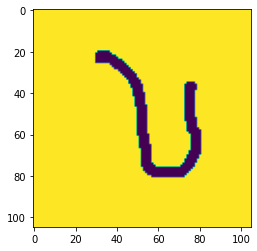

In [ ]:
%matplotlib inline
plt.imshow(Xtrain[2][12])
print(Xtrain[2][3].shape)
print(Xtrain.shape)
# alpha_char

method to generate a batch with required batch_size for training and testing

In [ ]:
def get_batch(batch_size, s="train"):
  if s == "train":
    n_classes, n_examples, w, h = Xtrain.shape
  else:
    n_classes, n_examples, w, h = Xval.shape
  cat_g = np.random.choice(n_classes, size = (batch_size), replace=False)
  tar_g = np.concatenate((np.zeros(batch_size//2), np.ones(batch_size//2)))
  pairs = [np.zeros((batch_size, h, w, 1)) for i in range(2)]

  for i in range(batch_size):
    cat_now, idx1, idx2 = cat_g[i], np.random.randint(n_examples), np.random.randint(n_examples)
    pairs[0][i,:,:,:] = Xtrain[cat_now, idx1].reshape(w, h, 1)
    
    if i > batch_size//2:# select always same category pics
      cat_now_2 = cat_g[i]
    else:# select always diff category pics
      cat_now_2  = (np.random.randint(n_classes) + cat_g[i])%n_classes

    pairs[1][i,:,:,:] = Xtrain[cat_now_2, idx2].reshape(w, h, 1)
  
  return pairs, tar_g


one shot learning method

In [ ]:
from sklearn.utils import shuffle

def make_oneshot_task1(N, s = "val"):

  if s == 'train':
    X = Xtrain
  else:
    X = Xval

  n_classes, n_examples, w, h = X.shape
  # chose random N image classes & random N examples for those selected classes 
  rnd_clss, rnd_img = np.random.choice(n_classes, N, replace = False), np.random.choice(n_examples, N)
  # choose 1 random true class category & all image examples selected above & N truth values 
  supp_img, targ, tru_cls, idx3 = X[rnd_clss, rnd_img], np.zeros(N), np.random.choice(n_classes), np.random.choice(N)
  idx1, idx2 = np.random.choice(n_examples, 2, replace = False) 
  supp_img[idx3], test_img, targ[idx3] = X[tru_cls, idx1], np.array([X[tru_cls, idx2] for i in range(N)]), 1
  # choose a ranodm example under true category & set the 1st index of true values as true(u can set any index)
  # reshape supp and test images where test images are N true image examples to be matched with all examples of supp & will be onlly ture for it's 1st index
  supp_img, test_img = supp_img.reshape((N, w, h, 1)), test_img.reshape((N, w, h, 1))
  supp_img, test_img, targ = shuffle(supp_img, test_img, targ)
  pairs = [test_img, supp_img]

  return pairs, targ


def test_oneshot1(model, N, k, s = "val"):
  n_correct = 0
  for i in range(k):
      inputs, targets = make_oneshot_task1(N, s)
      probs = model.predict(inputs)
      if np.argmax(probs) == np.argmax(targets):
        n_correct+=1
  percent_correct = (100.0 * n_correct / k)
  return percent_correct

Training and testing starts with different parameters for models, i have followed 2 styles with different iterations for training

In [ ]:
os.mkdir('data')
os.mkdir('logs')
# shutil.rmtree('data')
# shutil.rmtree('logs')
# os.listdir('.')

In [ ]:
# to be used only for fit_generate(in new TF only fit)
def data_generate(batch_size, s="train"):
  n = 0
  while True:
    pairs, targets = get_batch(batch_size, s)
    yield (pairs, targets)
    n+=1

train_generate = data_generate(32)
val_generate = data_generate(16, 'val')

Training with generators and checkpoints for 100 iterations

In [ ]:
checkpoint_filepath = 'data/model_weights.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, 
                                       monitor='val_loss', mode='max', save_best_only=True )
earlystop = callbacks.EarlyStopping(patience=10)
logdir = os.path.join("logs")
tensorboard = callbacks.TensorBoard(logdir, histogram_freq=1)
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
# Tried rnning tensorboard in various ways in colab but was unsuccessful

# %load_ext tensorboard
# import tensorboard
# tensorboard.__version__
# !rm -rf ./logs/
# !tensorboard --logdir logs
# from tensorboard import notebook
# notebook.list()
# !rm -rf ./logs/
# !tensorboard --logdir=logs --host=127.0.0.1

In [ ]:
shutil.rmtree('data')
os.mkdir('data')
checkpoint_filepath = 'data/model_weights.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, 
                                       monitor='val_loss', mode='max', save_best_only=True )
earlystop = callbacks.EarlyStopping(patience=10)
model, opt = get_siamese_model((105, 105, 1)), Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=opt)

In [ ]:
mod_hist = model.fit_generator(train_generate, steps_per_epoch = 964//32, epochs = 100,  
                               validation_data = val_generate, validation_steps = 659//16, 
                               callbacks=[checkpoint, earlystop])

Testing with different sizes of N in n-way one shot learning

In [ ]:
model.load_weights('data/model_weights.h5')
ways = np.arange(1, 30, 2)# size of N
val_accs, train_accs, nn_accs = [], [], []
trials = 450# no of instances with the above N
for N in ways:
    val_accs.append(test_oneshot1(model, N, trials, "val"))
    train_accs.append(test_oneshot1(model, N, trials, "train"))

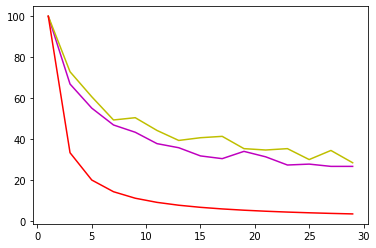

In [ ]:
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, 100.0/ways, "r")

plt.show()

Clearing previous stored weights to train in the style mentioned in repo, with same amount of iterations

In [ ]:
shutil.rmtree('data')
os.mkdir('data')

model, opt = get_siamese_model((105, 105, 1)), Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=opt)

In [ ]:
batch, n_iter, N_way, eval_iter, best, loss_iter, n_val = 32, 100, 20, 10, -1, 20, 250
data_path = os.path.join('data/')
weights_path_2 = os.path.join(data_path, "model_weights.h5")

for i in range(1, n_iter):
  inp, tar = get_batch(batch)
  loss = model.train_on_batch(inp, tar)
  print("\n ------------- \n")
  print("Loss: {0}".format(loss)) 
  if i % eval_iter == 0:
      print("iterations: {0}".format(i))
      val_acc = test_oneshot1(model, N_way, n_val)
      print(val_acc)
      if val_acc >= best:
          print("Current best: {0}, previous best: {1}".format(val_acc, best))
          print("Saving weights to: {0} \n".format(data_path))
          model.save_weights(weights_path_2)
          best = val_acc
  if i % loss_iter == 0:
      print("iteration {}, training loss: {:.2f},".format(i,loss))

testing the previous way

In [ ]:
model.load_weights('data/model_weights.h5')
ways = np.arange(1, 30, 2)
val_accs, train_accs, nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot1(model, N, trials, "val"))
    train_accs.append(test_oneshot1(model, N, trials, "train"))

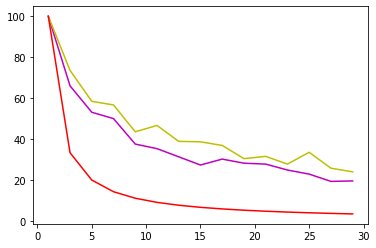

In [ ]:
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, 100.0/ways, "r")

plt.show()

Training with 500 epochs using fit_generate

In [ ]:
shutil.rmtree('data')
os.mkdir('data')

model, opt = get_siamese_model((105, 105, 1)), Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy", optimizer=opt)

In [ ]:
checkpoint_filepath = 'data/model_weights.h5'
checkpoint = callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, 
                                       monitor='val_loss', mode='max', save_best_only=True )
earlystop = callbacks.EarlyStopping(patience=50)

In [ ]:
mod_hist = model.fit_generator(train_generate, steps_per_epoch = 964//32, epochs = 500,  
                               validation_data = val_generate, validation_steps = 659//16, 
                               callbacks=[checkpoint, earlystop])

In [ ]:
model.load_weights('data/model_weights.h5')
ways = np.arange(1, 30, 2)
val_accs, train_accs, nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot1(model, N, trials, "val"))
    train_accs.append(test_oneshot1(model, N, trials, "train"))

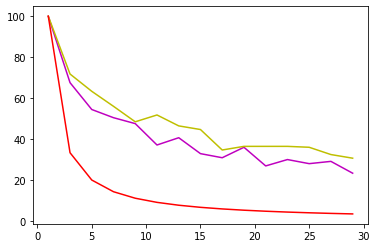

In [ ]:
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, 100.0/ways, "r")

plt.show()

The repo trained for around 20k iterations so i ran a 10k iterations following the same method

In [ ]:
batch, n_iter, N_way, eval_iter, best, loss_iter, n_val = 32, 10000, 20, 10, -1, 20, 250
data_path = os.path.join('data/')
weights_path_2 = os.path.join(data_path, "model_weights.h5")

for i in range(1, n_iter):
  inp, tar = get_batch(batch)
  loss = model.train_on_batch(inp, tar)
  print("\n ------------- \n")
  print("Loss: {0}".format(loss)) 
  if i % eval_iter == 0:
      print("iterations: {0}".format(i))
      val_acc = test_oneshot1(model, N_way, n_val)
      print(val_acc)
      if val_acc >= best:
          print("Current best: {0}, previous best: {1}".format(val_acc, best))
          print("Saving weights to: {0} \n".format(data_path))
          model.save_weights(weights_path_2)
          best = val_acc
  if i % loss_iter == 0:
      print("iteration {}, training loss: {:.2f},".format(i,loss))

In [ ]:
model.load_weights('data/model_weights.h5')
ways = np.arange(1, 30, 2)
val_accs, train_accs, nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot1(model, N, trials, "val"))
    train_accs.append(test_oneshot1(model, N, trials, "train"))

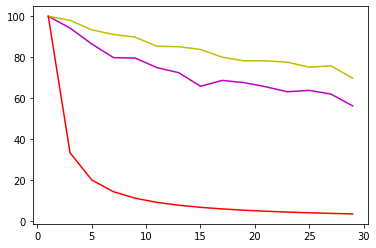

In [ ]:
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, 100.0/ways, "r")

plt.show()